### exercise 4 selection and regularization

### task 2: stepwise selection and regularization  

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import KFold, cross_validate
from itertools import combinations

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso

In [2]:
d = pd.read_csv(r'C:\Users\Chijun Zhang\Documents\jupyter\machine learning exercise\datasets\auto-mpg.csv')
print(d)

      mpg  cylinders  displacement     hp  weight  acceleration  year  origin
0    18.0          8         307.0  130.0  3504.0          12.0    70       1
1    15.0          8         350.0  165.0  3693.0          11.5    70       1
2    18.0          8         318.0  150.0  3436.0          11.0    70       1
3    16.0          8         304.0  150.0  3433.0          12.0    70       1
4    17.0          8         302.0  140.0  3449.0          10.5    70       1
..    ...        ...           ...    ...     ...           ...   ...     ...
387  27.0          4         140.0   86.0  2790.0          15.6    82       1
388  44.0          4          97.0   52.0  2130.0          24.6    82       2
389  32.0          4         135.0   84.0  2295.0          11.6    82       1
390  28.0          4         120.0   79.0  2625.0          18.6    82       1
391  31.0          4         119.0   82.0  2720.0          19.4    82       1

[392 rows x 8 columns]


In [3]:
label_column = 'mpg'
feature_columns = [c for c in d.columns if c != label_column]
X = d[feature_columns].values
y = d[label_column].values
p = len(feature_columns)

### Best subset selection

In [4]:
model = make_pipeline(StandardScaler(),LinearRegression())
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

In [5]:
best_features = []

best_mse = float('Inf')

for set_size in range(1, p + 1):

    comb = combinations(feature_columns, set_size)    
    
    for feature_set in comb:
        
        restricted_X = d[list(feature_set)].values
        scores = cross_validate(model, restricted_X, y, scoring='neg_mean_squared_error', cv=kfold)

        mse = np.mean(scores['test_score']) * -1
        
        if mse < best_mse:
            best_features = feature_set
            best_mse = mse

In [6]:
print("Best set of features:")
for f in best_features:
    print(f"\t{f}")
    
print("Features left out:")
for f in set(feature_columns) - set(best_features):
    print(f"\t{f}")

print(f"MSE of the best model: {best_mse:.3f}")

Best set of features:
	cylinders
	displacement
	hp
	weight
	year
	origin
Features left out:
	acceleration
MSE of the best model: 11.352


### Forward stepwise selection

In [7]:
def get_base_mse(y):
    predictions = [np.mean(y)] * len(y)
    return mean_squared_error(predictions, y)

def k_fold_mse(X, y):
    scores = cross_validate(model, X, y, scoring = 'neg_mean_squared_error', cv = kfold)
    return np.mean(scores['test_score']) * -1

def forward_stepwise_selection(X, y):

    current_mse = get_base_mse(y)
    
    current_features = np.array([], dtype = int)
    
    all_features = np.arange(len(feature_columns))
    
    while not np.array_equal(current_features, all_features):

        selected_feature = None
        
        for feature in (set(all_features) - set(current_features)):
    
            new_features = np.append(current_features, feature)
            
            mse = k_fold_mse(X[:,new_features], y)
            
            if mse < current_mse:
                current_mse = mse
                selected_feature = feature
                
        if selected_feature is not None:
            current_features = np.append(current_features, selected_feature)
        else:
            break
    
    return current_features, current_mse

In [8]:
features, mse = forward_stepwise_selection(X, y)

In [9]:
print("Selected features:")
for idx in sorted(features):
    print(f"\t{d.columns[idx + 1]}")

print("Features left out:")
for idx in (set(range(len(feature_columns))) - set(features)):
    print(f"\t{d.columns[idx + 1]}")
    
print(f"MSE of the selected model: {mse:.3f}")

Selected features:
	cylinders
	displacement
	hp
	weight
	year
	origin
Features left out:
	acceleration
MSE of the selected model: 11.352


### Backward stepwise selection

In [10]:
def backward_stepwise_selection(X, y):

    current_mse = k_fold_mse(X, y)
    
    current_features = np.arange(len(feature_columns)) 
    
    best_mse = current_mse

    best_features = current_features[:]
    
    while len(current_features) > 0:
        
        selected_feature = None
        
        for feature in current_features:
            
            new_features = np.delete(current_features, np.where(current_features == feature))
            
            mse = k_fold_mse(X[:,new_features], y)
            
            if mse < current_mse:
                selected_feature = feature
                current_mse = mse
        
        if selected_feature is not None:
            current_features = np.delete(current_features, np.where(current_features == selected_feature))
        else:
            break
    
    if current_mse < get_base_mse(y):
        return current_features, current_mse
    else:
        return [], get_base_mse(y)
    

In [11]:
features, mse = backward_stepwise_selection(X, y)

In [12]:
print("Selected features:")
for idx in sorted(features):
    print(f"\t{d.columns[idx + 1]}")

print("Features left out:")
for idx in (set(range(len(feature_columns))) - set(features)):
    print(f"\t{d.columns[idx + 1]}")
    
print(f"MSE of the selected model: {mse:.3f}")

Selected features:
	cylinders
	displacement
	hp
	weight
	year
	origin
Features left out:
	acceleration
MSE of the selected model: 11.352


### Ridge Regression

In [13]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
model = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree=2),
    GridSearchCV(
        estimator = Ridge(),
        cv = kfold,
        scoring = 'neg_mean_squared_error',
        
        param_grid = {'alpha': np.logspace(-3, 2, 50)}
    )
)

In [14]:
model.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomialfeatures', PolynomialFeatures()),
                ('gridsearchcv',
                 GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
                              estimator=Ridge(),
                              param_grid={'alpha': array([1.00000000e-03, 1.26485522e-03, 1.59985872e-03, 2.02358965e-03,
       2.55954792e-03, 3.23745754e-03, 4.09491506e-03, 5.17947468e-03,
       6.55128557e...
       7.19685673e-01, 9.10298178e-01, 1.15139540e+00, 1.45634848e+00,
       1.84206997e+00, 2.32995181e+00, 2.94705170e+00, 3.72759372e+00,
       4.71486636e+00, 5.96362332e+00, 7.54312006e+00, 9.54095476e+00,
       1.20679264e+01, 1.52641797e+01, 1.93069773e+01, 2.44205309e+01,
       3.08884360e+01, 3.90693994e+01, 4.94171336e+01, 6.25055193e+01,
       7.90604321e+01, 1.00000000e+02])},
                              scoring='neg_mean_squared_error'))])

In [15]:
lambdas = [p['alpha'] for p in model[2].cv_results_['params']]
mses = [neg_mse * -1 for neg_mse in model[2].cv_results_['mean_test_score']]

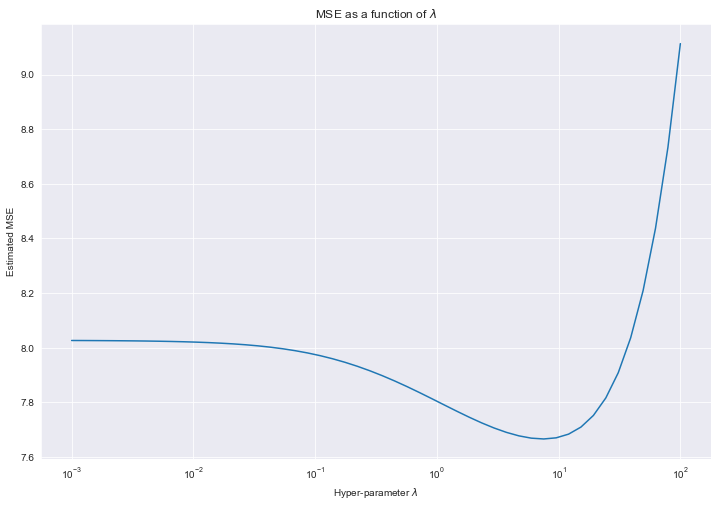

In [16]:
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(lambdas, mses)
ax.set_xscale('log')
ax.set_title(r"MSE as a function of $\lambda$")
ax.set_xlabel(r"Hyper-parameter $\lambda$")
ax.set_ylabel("Estimated MSE");

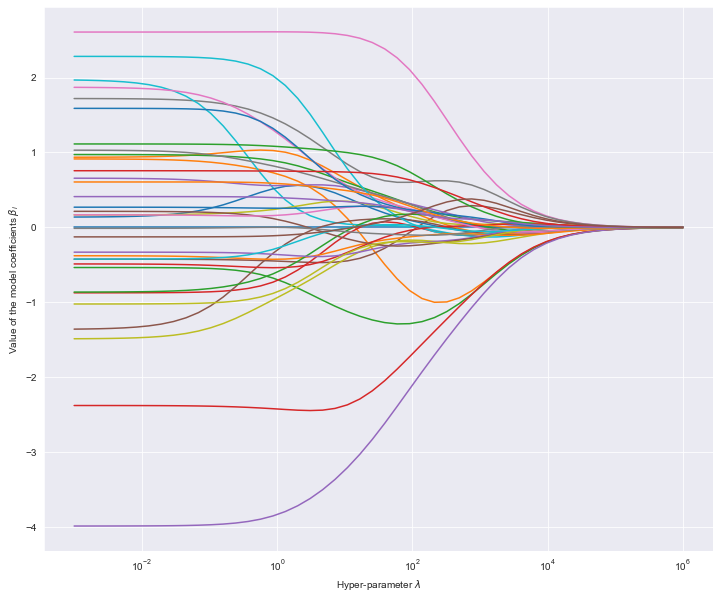

In [17]:
lambdas = np.logspace(-3, 6, 50)
coefficients = list()

for lam in lambdas:
    model = make_pipeline(
        StandardScaler(),
        PolynomialFeatures(degree = 2),
        Ridge(alpha = lam)
    )
    model.fit(X, y)
    coefficients.append(model[2].coef_)

coefficients = np.array(coefficients).T
fig, ax = plt.subplots(figsize = (12, 10))

for coef_vals in coefficients:
    ax.plot(lambdas, coef_vals)
    
ax.set_xlabel(r"Hyper-parameter $\lambda$")
ax.set_ylabel(r"Value of the model coefficients $\beta_i$")
ax.set_xscale('log');

### Lasso

In [18]:
model = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree = 2),
    GridSearchCV(
        estimator = Lasso(max_iter = 10000, tol = 0.05),
        cv = kfold,
        scoring = 'neg_mean_squared_error',
        param_grid = {'alpha': np.logspace(-3, 2, 50)}
    )
)

In [19]:
model.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomialfeatures', PolynomialFeatures()),
                ('gridsearchcv',
                 GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
                              estimator=Lasso(max_iter=10000, tol=0.05),
                              param_grid={'alpha': array([1.00000000e-03, 1.26485522e-03, 1.59985872e-03, 2.02358965e-03,
       2.55954792e-03, 3.23745754e-03, 4.09491506e-03, 5.1...
       7.19685673e-01, 9.10298178e-01, 1.15139540e+00, 1.45634848e+00,
       1.84206997e+00, 2.32995181e+00, 2.94705170e+00, 3.72759372e+00,
       4.71486636e+00, 5.96362332e+00, 7.54312006e+00, 9.54095476e+00,
       1.20679264e+01, 1.52641797e+01, 1.93069773e+01, 2.44205309e+01,
       3.08884360e+01, 3.90693994e+01, 4.94171336e+01, 6.25055193e+01,
       7.90604321e+01, 1.00000000e+02])},
                              scoring='neg_mean_squared_error'))])

In [20]:
lambdas = [p['alpha'] for p in model[2].cv_results_['params']]
mses = [neg_mse * -1 for neg_mse in model[2].cv_results_['mean_test_score']]

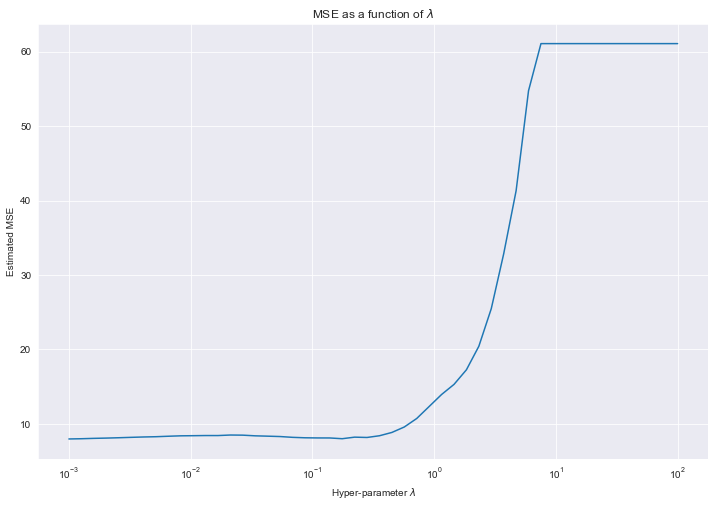

In [21]:
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(lambdas, mses)
ax.set_xscale('log')
ax.set_title(r"MSE as a function of $\lambda$")
ax.set_xlabel(r"Hyper-parameter $\lambda$")
ax.set_ylabel("Estimated MSE");

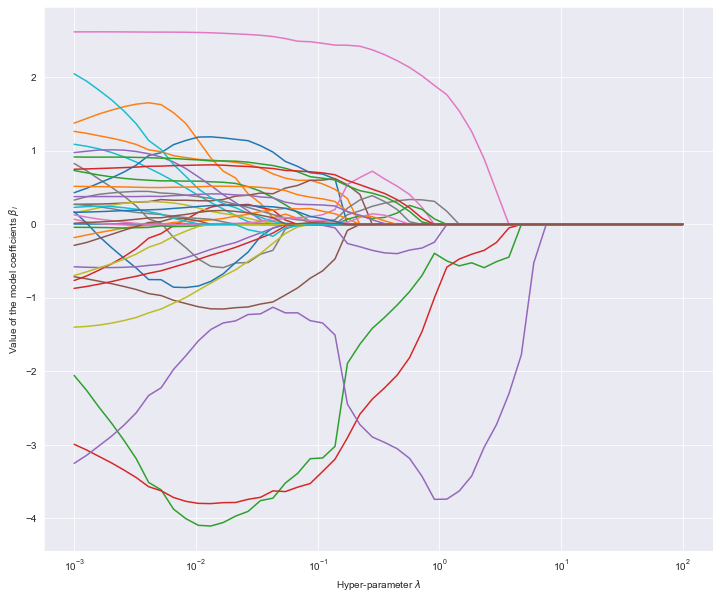

In [22]:
lambdas = np.logspace(-3, 2, 50)
coefficients = list()

for lam in lambdas:
    model = make_pipeline(
        StandardScaler(),
        PolynomialFeatures(degree = 2),
        Lasso(alpha = lam, max_iter = 10000, tol = 0.05)
    )
    model.fit(X, y)
    coefficients.append(model[2].coef_)

coefficients = np.array(coefficients).T
fig, ax = plt.subplots(figsize = (12, 10))

for coef_vals in coefficients:
    ax.plot(lambdas, coef_vals)
    
ax.set_xlabel(r"Hyper-parameter $\lambda$")
ax.set_ylabel(r"Value of the model coefficients $\beta_i$")
ax.set_xscale('log');

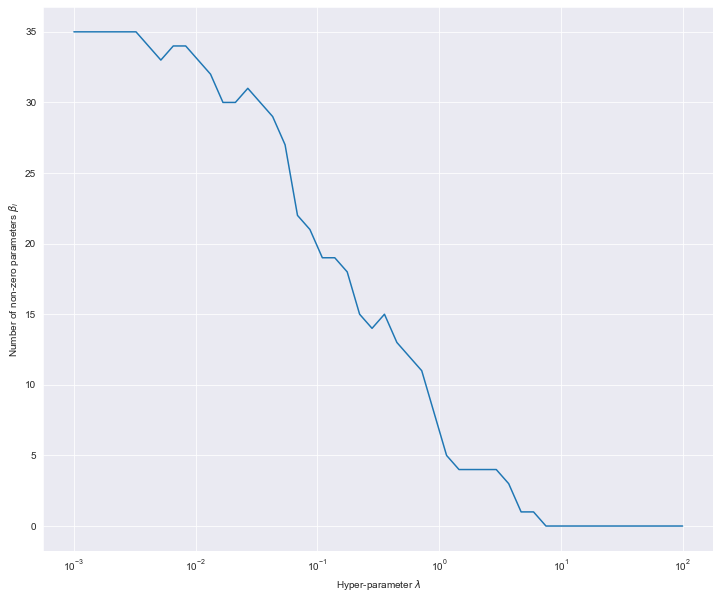

In [23]:
num_lambdas = 50

non_zeroes = [len([cf[i] for cf in coefficients if cf[i] != 0]) for i in range(num_lambdas)]

fig, ax = plt.subplots(figsize = (12, 10))

ax.plot(lambdas, non_zeroes)
    
ax.set_xlabel(r"Hyper-parameter $\lambda$")
ax.set_ylabel(r"Number of non-zero parameters $\beta_i$")
ax.set_xscale('log');